# Data Analysis

## Setup
Import libraries, load dataframes, and get some basic information.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
bank_churn_df = pd.read_csv("./data/ChurnForBankCustomers.csv")
display(bank_churn_df.head())
display(bank_churn_df.dtypes)
display(f"Number of entries is {len(bank_churn_df)} with {len(bank_churn_df.columns)} variables.")

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

'Number of entries is 10000 with 14 variables.'

In [3]:
telco_churn_df = pd.read_csv("./data/TelcoCustomerChurn.csv")
display(telco_churn_df.head())
display(telco_churn_df.dtypes)
display(f"Number of entries is {len(telco_churn_df)} with {len(telco_churn_df.columns)} variables.")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

'Number of entries is 7043 with 21 variables.'

In [4]:
sachs_df = pd.read_csv("./data/sachs.txt", delimiter="	")
display(sachs_df.head())
display(sachs_df.dtypes)
display(f"Number of entries is {len(telco_churn_df)} with {len(telco_churn_df.columns)} variables.")

,raf,mek,plc,pip2,pip3,erk,akt,pka,pkc,p38,jnk,cd3_cd28,icam2,aktinhib,g0076,psitect,u0126,ly,pma,b2camp
0,3.5946,3.1442,2.9349,3.3429,4.2312,2.8100,3.2958,6.0497,3.2958,4.0055,3.9120,0.9932,0.0070,-0.0095,-0.0142,-0.0231,-0.0187,0.0133,0.0004,-0.0067
1,3.8265,3.2771,3.1046,3.2884,2.8976,3.3534,3.7495,5.8916,2.5930,3.2771,4.2697,0.9989,0.0052,-0.0031,0.0152,-0.0035,0.0050,-0.0032,0.0042,0.0130
2,4.2399,3.9908,3.2027,3.0057,3.1355,3.2149,3.7495,6.0234,3.0634,3.7353,3.3844,1.0179,0.0178,-0.0011,0.0071,0.0070,0.0067,-0.0007,0.0096,-0.0068
3,4.4188,4.5304,3.4995,3.1570,2.4239,2.7619,3.0819,6.2879,3.1655,3.6533,3.4995,1.0031,-0.0114,0.0088,-0.0153,-0.0031,0.0082,-0.0022,-0.0023,-0.0038
4,3.7773,3.3945,2.7206,2.9821,3.5496,3.4372,4.0271,5.7526,2.6851,3.5752,4.5142,1.0098,0.0019,-0.0062,0.0016,0.0036,-0.0014,-0.0060,-0.0108,0.0162


raf         float64
mek         float64
plc         float64
pip2        float64
pip3        float64
erk         float64
akt         float64
pka         float64
pkc         float64
p38         float64
jnk         float64
cd3_cd28    float64
icam2       float64
aktinhib    float64
g0076       float64
psitect     float64
u0126       float64
ly          float64
pma         float64
b2camp      float64
dtype: object

'Number of entries is 7043 with 21 variables.'

## Visualization
View the data distribution in each dataset.

/var/folders/0s/xmhj41h5287f7dwtvtxnfncw0000gn/T/ipykernel_30837/2255471800.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(bank_churn_df.corr(), annot=True, fmt=".2f", vmax="0.5", ax=ax)


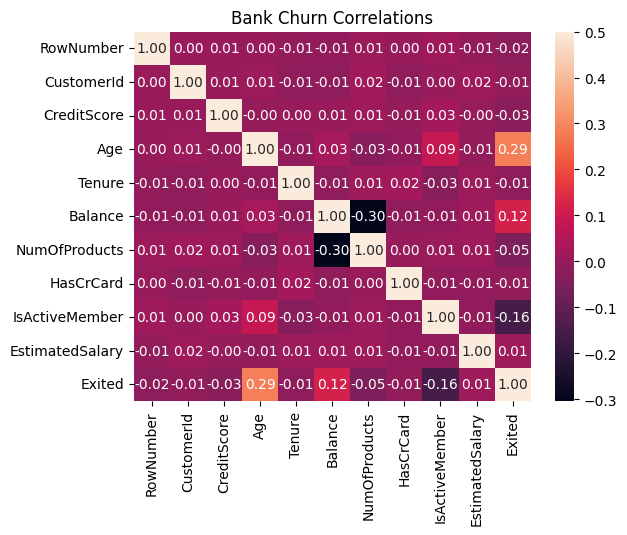

In [4]:
ax = plt.axes()

sns.heatmap(bank_churn_df.corr(), annot=True, fmt=".2f", vmax="0.5", ax=ax)
ax.set_title("Bank Churn Correlations")

plt.show()

/var/folders/0s/xmhj41h5287f7dwtvtxnfncw0000gn/T/ipykernel_30837/3247258246.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(telco_churn_df.corr(), annot=True, fmt=".2f", vmax="0.5", ax=ax)


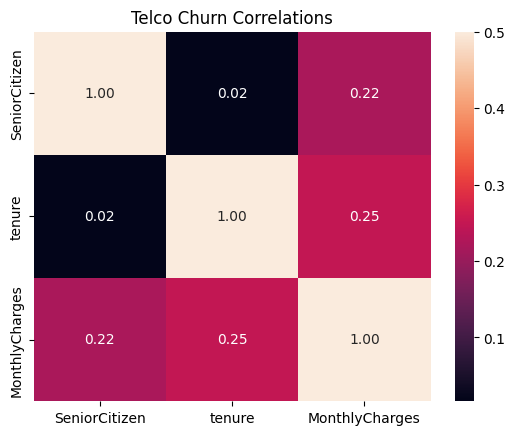

In [5]:
ax = plt.axes()

sns.heatmap(telco_churn_df.corr(), annot=True, fmt=".2f", vmax="0.5", ax=ax)
ax.set_title("Telco Churn Correlations")

plt.show()

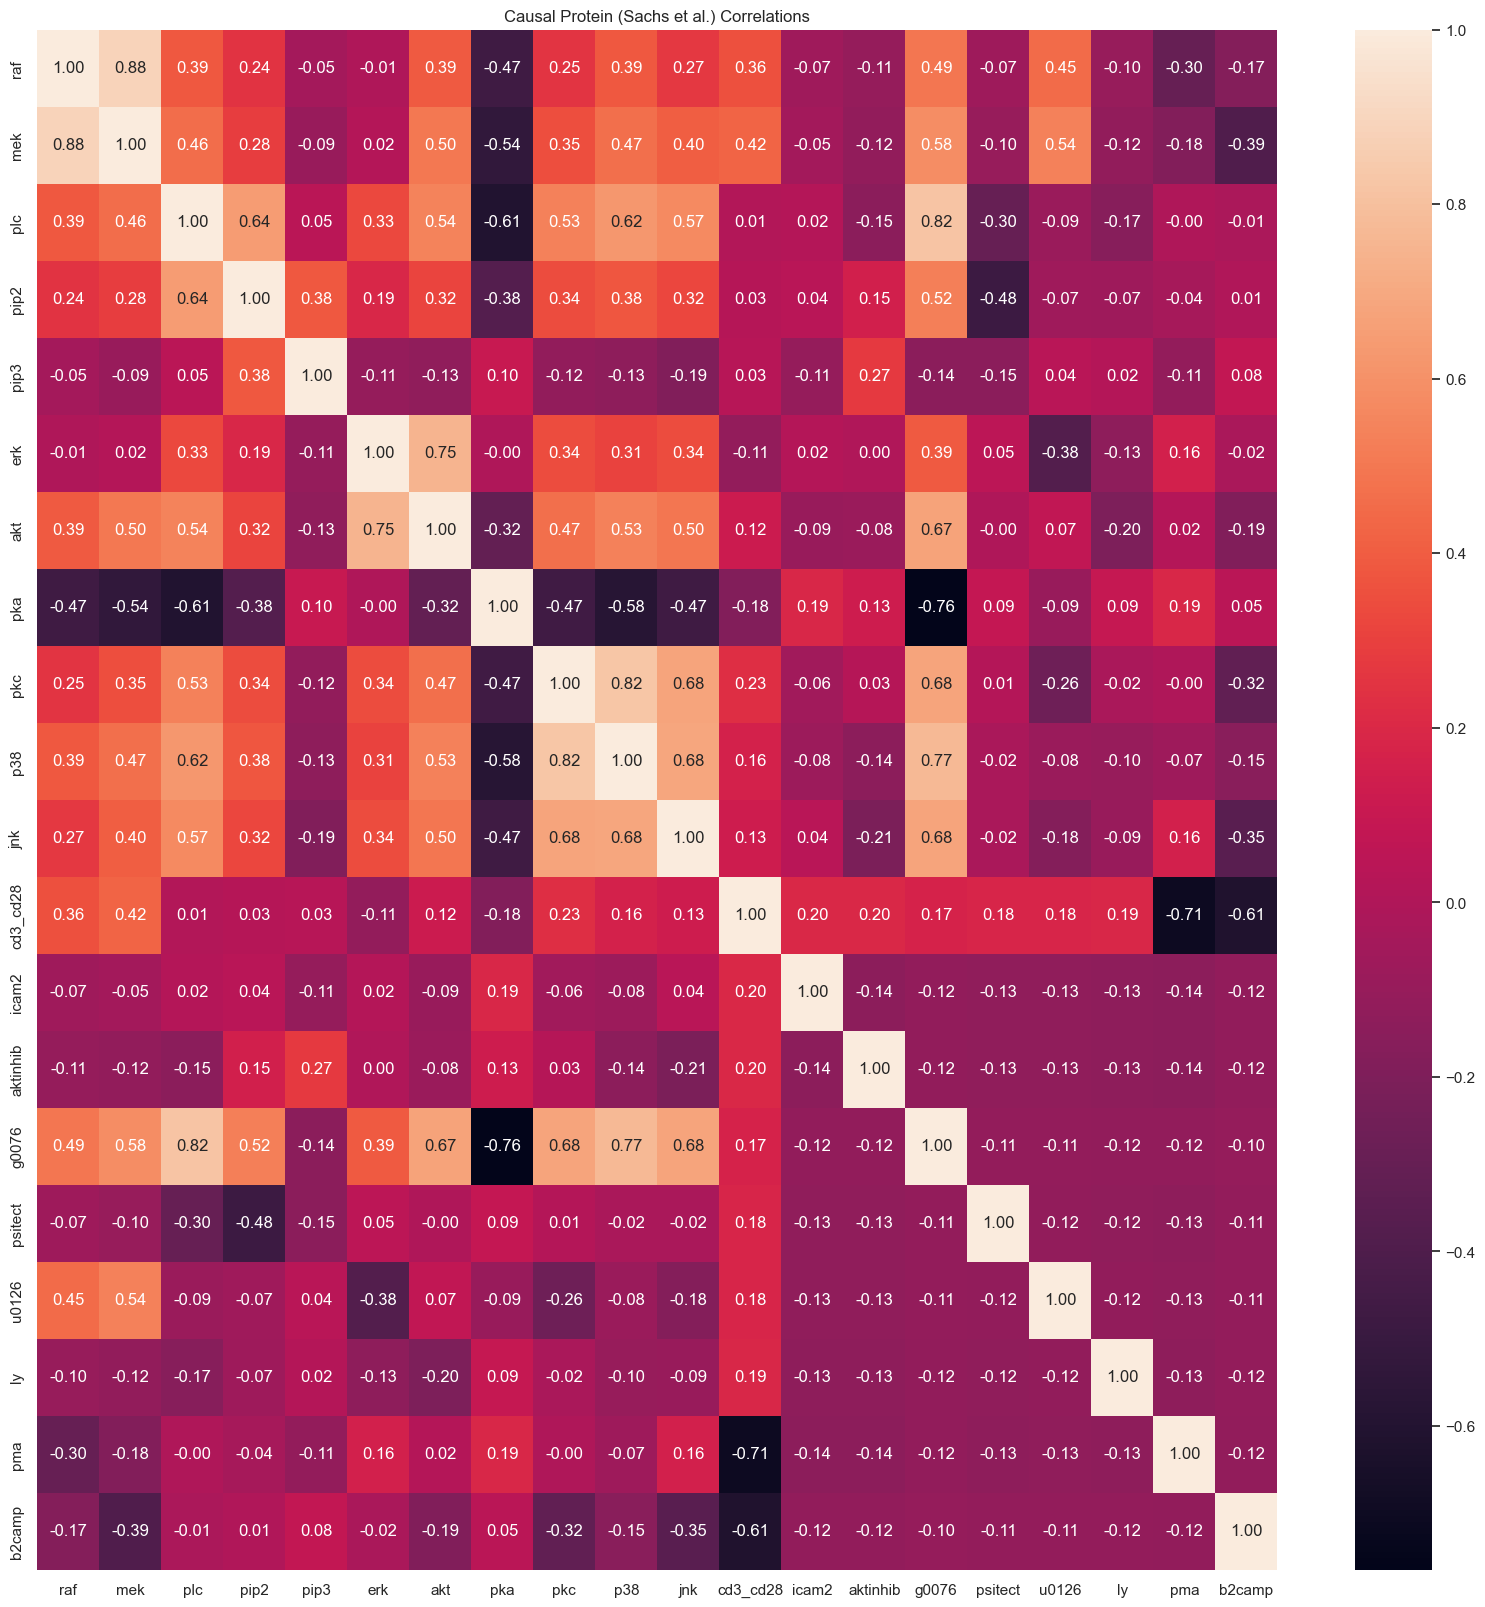

In [10]:
ax = plt.axes()

sns.heatmap(sachs_df.corr(), annot=True, fmt=".2f", ax=ax)
ax.set_title("Causal Protein (Sachs et al.) Correlations")
sns.set(rc={'figure.figsize':(20,20)})

plt.show()